In [1]:
%matplotlib ipympl

In [2]:
import emg3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### reprNew

In [3]:
names = [
    'New',
    'New-Iter50',
    'New-Iter50-log',
    'New-Iter30',
    'New-Iter30-Gradm4',
]

data = {}
for name in names:
    dat = {}
    values = emg3d.load(f"DevInv-7x7-repr{name}.h5", verb=0)
    dat['simulation'] = values['simulation']
    values = values['invinfo']
    for prop in ['time', 'chi2', 'phi_d', 'phi_m', 'phi', 'phi_delta', 'count']:
        dat[prop] = np.array([it[prop] for it in values.values()])
        if prop == 'time':
            dat[prop] /= 3600
    dat['models'] = [it['model'] for it in values.values()]
    data[name] = dat

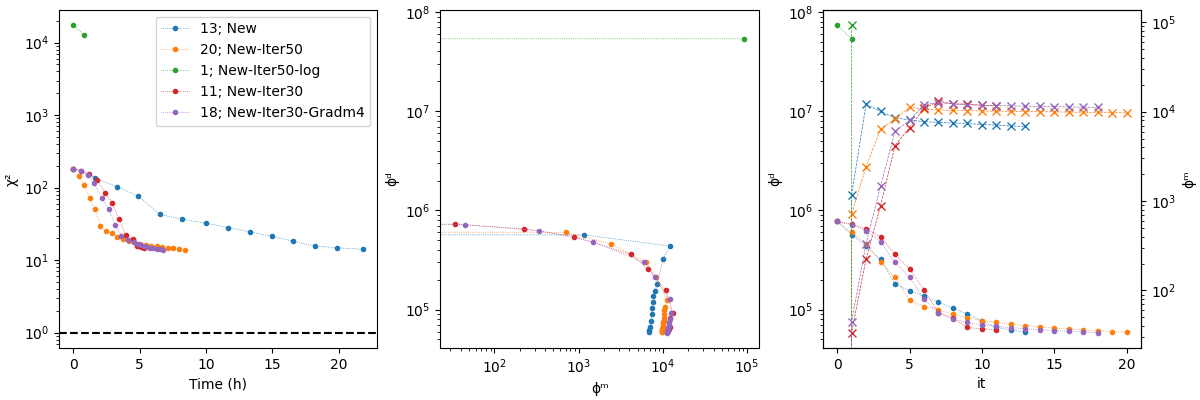

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
ax3b = ax3.twinx()
for i, (k, v) in enumerate(data.items()):
    ax1.semilogy(v['time'], v['chi2'], f'C{i}.:', lw=0.5, label=f"{v['chi2'].size-1}; {k}")
    ax2.loglog(v['phi_m'], v['phi_d'], f'C{i}.:', lw=0.5, label=f"{v['chi2'].size-1}; {k}")
    ax3.semilogy(v['phi_d'], f'C{i}.:', lw=0.5, label=f"{v['chi2'].size-1}; {k}")
    ax3b.semilogy(v['phi_m'], f'C{i}x--', lw=0.5, label=f"{v['chi2'].size-1}; {k}")
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('χ²')
ax2.set_ylabel('ϕᵈ')
ax2.set_xlabel('ϕᵐ')
ax3.set_xlabel('it')
ax3.set_ylabel('ϕᵈ')
ax3b.set_ylabel('ϕᵐ')
ax1.legend()
ax1.axhline(1, c='k', ls='--')

Data loaded from «/palmyra/data/dieterwerthmul/dev-pygimli-emg3d/pginv-7x7.h5»
[emg3d v1.8.4.dev11+g28220a0 (format 1.0) on 2024-07-10T15:14:12.205671].


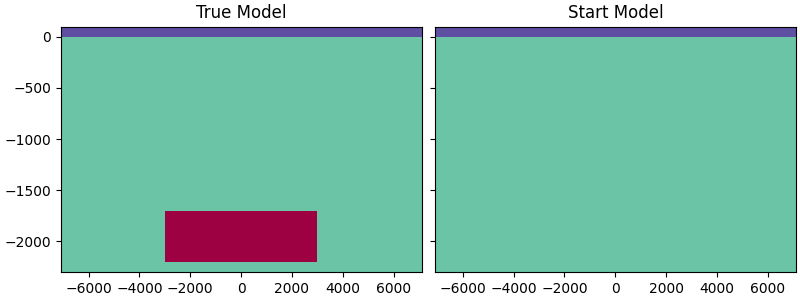

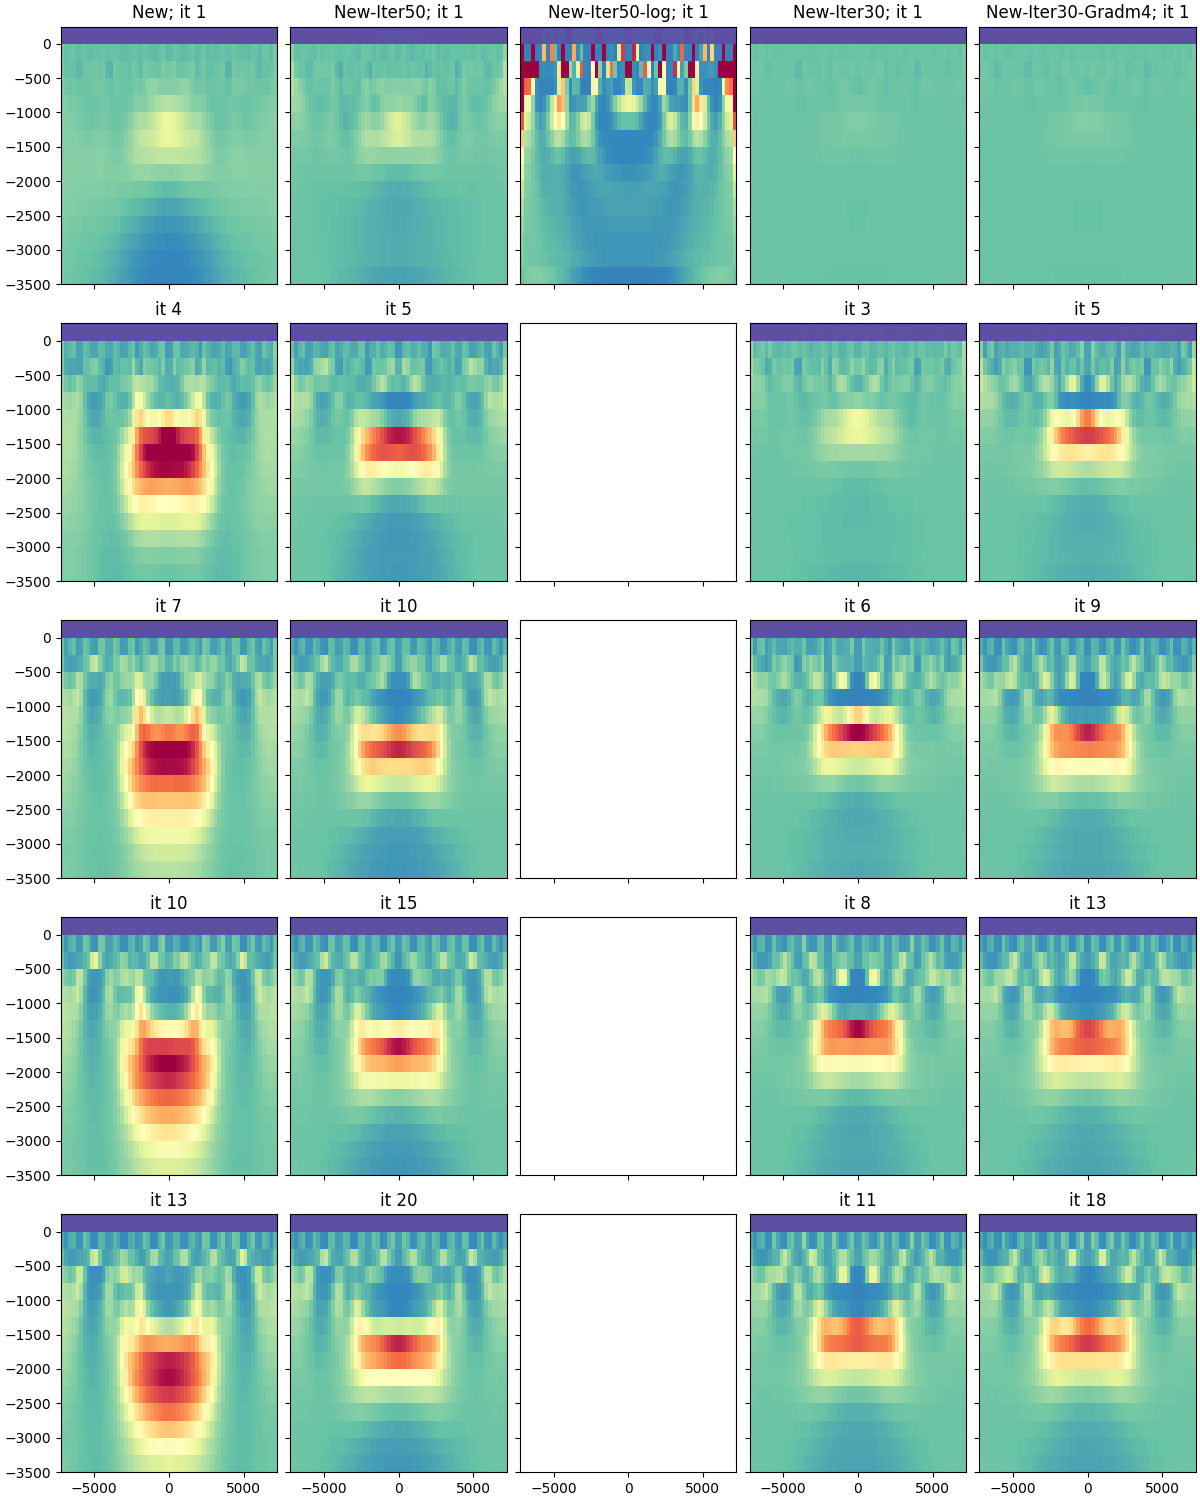

In [5]:
inp_data = emg3d.load('pginv-7x7.h5')
model_true = inp_data['true_model']
model_start = inp_data['model']

popts = {'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}


fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True, constrained_layout=True)

model_true.grid.plot_slice(model_true.property_x.ravel('F'), ax=axs[0],**opts)
axs[0].set_title("True Model")
model_start.grid.plot_slice(model_start.property_x.ravel('F'), ax=axs[1],**opts)
axs[1].set_title("Start Model")
for ax in axs.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')


fig, axs = plt.subplots(5, len(names), figsize=(12, 15), sharex=True, sharey=True, constrained_layout=True)

for i, (k, v) in enumerate(data.items()):
    ix = np.linspace(1, v['chi2'].size-1, 5, dtype=int)
    fi = 0
    for ii, model in enumerate(v['models']):
        if ii not in ix:
            continue
        out, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=axs[fi, i], **opts)
        if ii == 1:
            axs[fi, i].set_title(f"{k}; it {ii}")
        else:
            axs[fi, i].set_title(f"it {ii}")
        fi += 1    
for ax in axs.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')

In [6]:
dat = data['New-Iter50']
sim = dat['simulation']
if not hasattr(sim.data, 'inv'):
    sim.data['inv'] = sim.data[f"it{dat['chi2'].size-1}"]

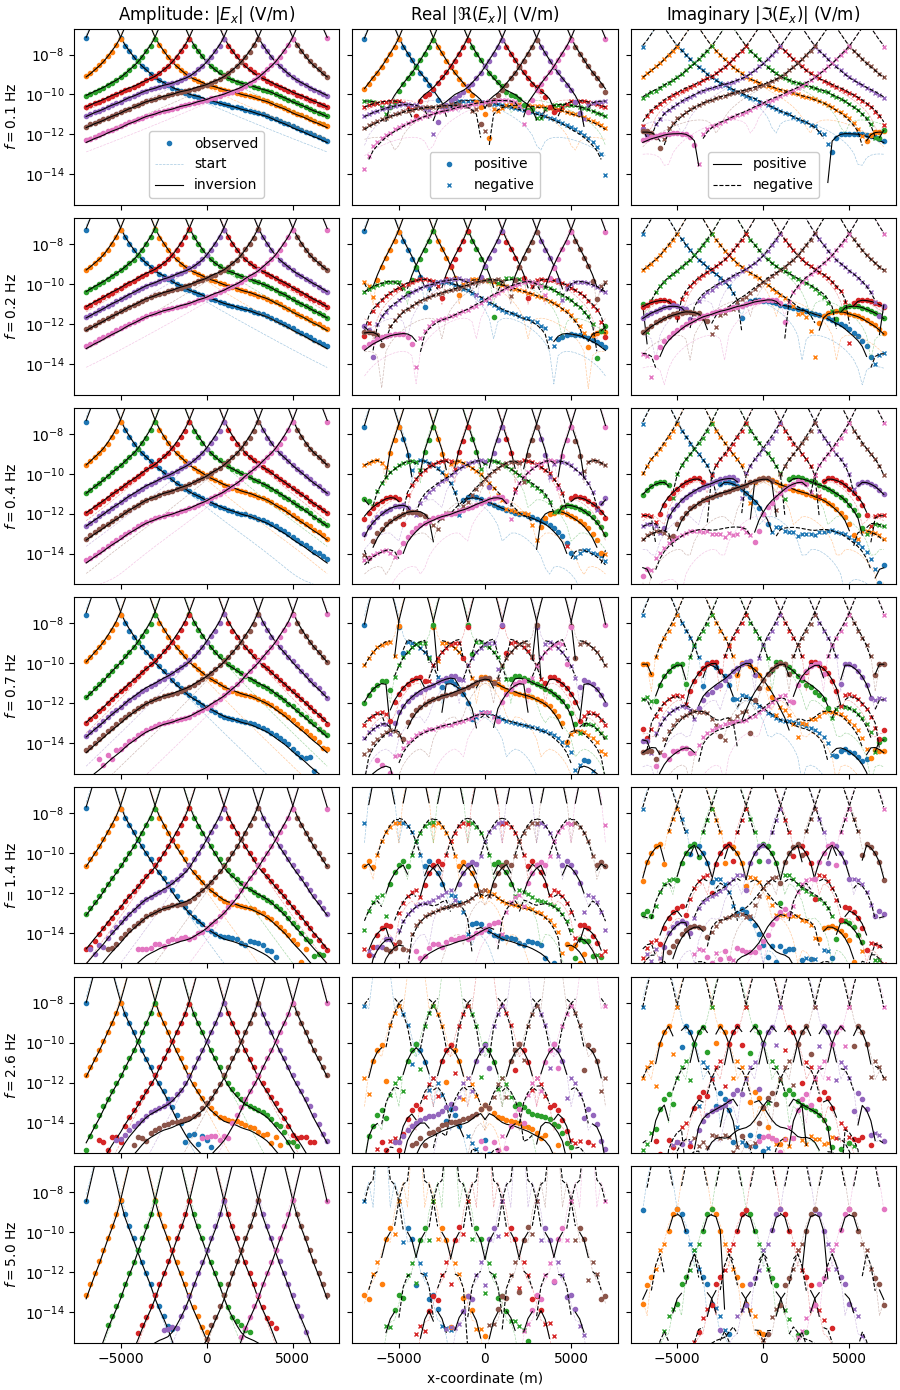

In [7]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.where(data > 0, data, np.nan)
    

height = sim.survey.shape[2]*1.7+2
fig, axs = plt.subplots(sim.survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

# Data
obs_resp = sim.data.observed
inv_resp = sim.data.inv
start_resp = sim.data.it0

rec_coords = sim.survey.receiver_coordinates()

for ii, freq in enumerate(sim.survey.frequencies.keys()):
    for i, src in enumerate(sim.survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        # obs_resperved data
        axs[ii, 0].plot(rec_coords[0], abs(obs_resp.loc[src, :, freq].data), f"C{i}.",
                        label='observed' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs_resp.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(-obs_resp.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs_resp.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], pos(-obs_resp.loc[src, :, freq].data.imag), f"C{i}x", ms=3)
        
        # Start model
        axs[ii, 0].plot(rec_coords[0], abs(start_resp.loc[src, :, freq].data), f"C{i}--", alpha=.4, lw=0.5,
                        label='start' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(start_resp.loc[src, :, freq].data.real), f"C{i}--", alpha=.4, lw=0.5)
        axs[ii, 2].plot(rec_coords[0], abs(start_resp.loc[src, :, freq].data.imag), f"C{i}--", alpha=.4, lw=0.5)
        
        # Inverted data
        axs[ii, 0].plot(rec_coords[0], abs(inv_resp.loc[src, :, freq].data), f"k-", lw=0.8,
                        label='inversion' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(inv_resp.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], pos(-inv_resp.loc[src, :, freq].data.real), f"k--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], pos(inv_resp.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(-inv_resp.loc[src, :, freq].data.imag), f"k--", lw=0.8,
                        label='negative' if i == 0 else '')
        

    axs[ii, 0].set_ylabel(f'$f={sim.survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
plt.savefig(f"{sim.name}.png", dpi=300)
#plt.show()

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Thu Jul 18 21:28:13 2024 CEST

                OS : Linux (Red Hat Enterprise Linux 8.10)
            CPU(s) : 128
           Machine : x86_64
      Architecture : 64bit
               RAM : 1006.8 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.58.1
             emg3d : 1.8.4.dev18+g4fd3e43
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.8.4
              tqdm : 4.66.4
           IPython : 8.26.0
--------------------------------------------------------------------------------

In [9]:
a = np.arange(19)
b = np.arange(11)
c = np.arange(13)

for x in [a, b, c]:
    n = x.size
    print(np.linspace(0, n, 10, dtype=int))

[ 0  2  4  6  8 10 12 14 16 19]
[ 0  1  2  3  4  6  7  8  9 11]
[ 0  1  2  4  5  7  8 10 11 13]


In [10]:
np.linspace(0, 10, 10, dtype=int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10])